Week 4 Notebook: Simple Classifiers
===============================================================

This week, we're going to build some simple classifiers.

In [3]:
import tensorflow.keras as keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot

In [30]:
# 27 jet-level features
features = ['fj_jetNTracks',
            'fj_nSV',
            'fj_tau0_trackEtaRel_0',
            'fj_tau0_trackEtaRel_1',
            'fj_tau0_trackEtaRel_2',
            'fj_tau1_trackEtaRel_0',
            'fj_tau1_trackEtaRel_1',
            'fj_tau1_trackEtaRel_2',
            'fj_tau_flightDistance2dSig_0',
            'fj_tau_flightDistance2dSig_1',
            'fj_tau_vertexDeltaR_0',
            'fj_tau_vertexEnergyRatio_0',
            'fj_tau_vertexEnergyRatio_1',
            'fj_tau_vertexMass_0',
            'fj_tau_vertexMass_1',
            'fj_trackSip2dSigAboveBottom_0',
            'fj_trackSip2dSigAboveBottom_1',
            'fj_trackSip2dSigAboveCharm_0',
            'fj_trackSipdSig_0',
            'fj_trackSipdSig_0_0',
            'fj_trackSipdSig_0_1',
            'fj_trackSipdSig_1',
            'fj_trackSipdSig_1_0',
            'fj_trackSipdSig_1_1',
            'fj_trackSipdSig_2',
            'fj_trackSipdSig_3',
            'fj_z_ratio']

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb (we'll reduce the following labels)
labels =  ['label_QCD_b',
           'label_QCD_bb',
           'label_QCD_c', 
           'label_QCD_cc', 
           'label_QCD_others',
           'sample_isQCD',
           'label_H_bb']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = 2

Let's set up a function to get features and labels.

In [11]:
def get_features_labels(file_name, remove_mass_pt_window=True, entrystop=None):
    # load file
    root_file = uproot.open(file_name)
    tree = root_file['deepntuplizer/tree']
    feature_array = tree.arrays(branches=features, 
                                entrystop=entrystop,
                                namedecode='utf-8')
    spec_array = tree.arrays(branches=spectators, 
                             entrystop=entrystop,
                             namedecode='utf-8')
    label_array_all = tree.arrays(branches=labels, 
                                  entrystop=entrystop,
                                  namedecode='utf-8')

    feature_array = np.stack([feature_array[feat] for feat in features],axis=1)
    spec_array = np.stack([spec_array[spec] for spec in spectators],axis=1)
    
    njets = feature_array.shape[0]
    
    label_array = np.zeros((njets,nlabels))
    label_array[:,0] = label_array_all['sample_isQCD'] * (label_array_all['label_QCD_b'] + \
                                                          label_array_all['label_QCD_bb'] + \
                                                          label_array_all['label_QCD_c'] + \
                                                          label_array_all['label_QCD_cc'] + \
                                                          label_array_all['label_QCD_others'])
    label_array[:,1] = label_array_all['label_H_bb']

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        label_array = label_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        spec_array = spec_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
    
    # remove unlabeled data
    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    spec_array = spec_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]

    return feature_array, label_array, spec_array

In [12]:
# load training file
feature_array, label_array, spec_array = get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root', 
                                                             remove_mass_pt_window=False,
                                                             entrystop=20000)

## Decision Tree Classifier

In [26]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(feature_array, label_array[:,1])

## Support Vector Machine Classifier

In [27]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(feature_array, label_array[:,1])

SGDClassifier()

## Fully Connected Neural Network Classifier

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization

# define dense keras model
inputs = Input(shape=(nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 27)                0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 27)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1792      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 5,102
Trainable params: 5,048
Non-trainable params: 54
________________________________________________________

In [14]:
# define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=5,factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
history = keras_model.fit(feature_array, label_array, batch_size=1024, 
                          epochs=100, validation_split=0.2, shuffle=False,
                          callbacks = callbacks, verbose=0)
# reload best weights
keras_model.load_weights('keras_model_best.h5')

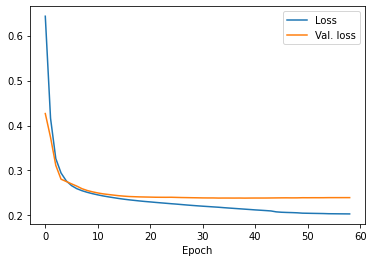

In [15]:
plt.figure()
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [16]:
# load testing file
feature_array_test, label_array_test, spec_array_test = get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root', 
                                                                            remove_mass_pt_window=True,
                                                                            entrystop=30000)

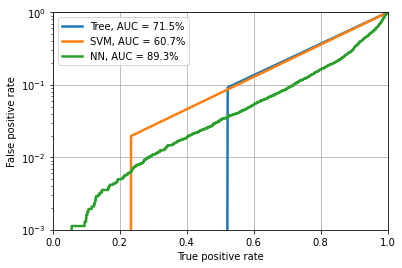

In [32]:
# run model inference on test data set
predict_array_nn = keras_model.predict(feature_array_test)
predict_array_tree = clf.predict(feature_array_test)
predict_array_svm = svm.predict(feature_array_test)

# create ROC curves
fpr_tree, tpr_tree, threshold_tree = roc_curve(label_array_test[:,1], predict_array_tree)
fpr_svm, tpr_svm, threshold_svm = roc_curve(label_array_test[:,1], predict_array_svm)
fpr_nn, tpr_nn, threshold_nn = roc_curve(label_array_test[:,1], predict_array_nn[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_tree, fpr_tree, lw=2.5, label="Tree, AUC = {:.1f}%".format(auc(fpr_tree,tpr_tree)*100))
plt.plot(tpr_svm, fpr_svm, lw=2.5, label="SVM, AUC = {:.1f}%".format(auc(fpr_svm,tpr_svm)*100))
plt.plot(tpr_nn, fpr_nn, lw=2.5, label="NN, AUC = {:.1f}%".format(auc(fpr_nn,tpr_nn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()